# 1. Setup

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 2. Load and prepare data

In [8]:
df = pd.read_csv("../data/tourism_clean.csv")

In [9]:
df["date"] = pd.to_datetime(df["date"])

In [10]:
df = df.set_index("date")

In [15]:
df["tourism_revenue_usd"] = pd.to_numeric(df["tourism_revenue_usd"], errors="coerce")

In [17]:
df = df.dropna(subset=["tourism_revenue_usd"])

In [19]:
revenue = df["tourism_revenue_usd"].resample("M").mean().fillna(method="ffill")

C:\Users\nimes\AppData\Local\Temp\ipykernel_20084\2641924149.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  revenue = df["tourism_revenue_usd"].resample("M").mean().fillna(method="ffill")
C:\Users\nimes\AppData\Local\Temp\ipykernel_20084\2641924149.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  revenue = df["tourism_revenue_usd"].resample("M").mean().fillna(method="ffill")


# 3. Train/Test split

In [20]:
train = revenue.iloc[:-12]
test = revenue.iloc[-12:]

print("Train period:", train.index.min(), "to", train.index.max())
print("Test period:", test.index.min(), "to", test.index.max())

Train period: 2010-01-31 00:00:00 to 2023-12-31 00:00:00
Test period: 2024-01-31 00:00:00 to 2024-12-31 00:00:00


# 4. Build SARIMAX model

In [21]:
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12), 
                enforce_stationarity=False, enforce_invertibility=False)

results = model.fit(disp=False)

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                tourism_revenue_usd   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2666.103
Date:                            Sat, 06 Sep 2025   AIC                           5342.207
Time:                                    14:48:17   BIC                           5356.950
Sample:                                01-31-2010   HQIC                          5348.198
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5019      0.287     -1.748      0.080      -1.064       0.061
ma.L1          0.6857      0.259   

# 5. Forecast

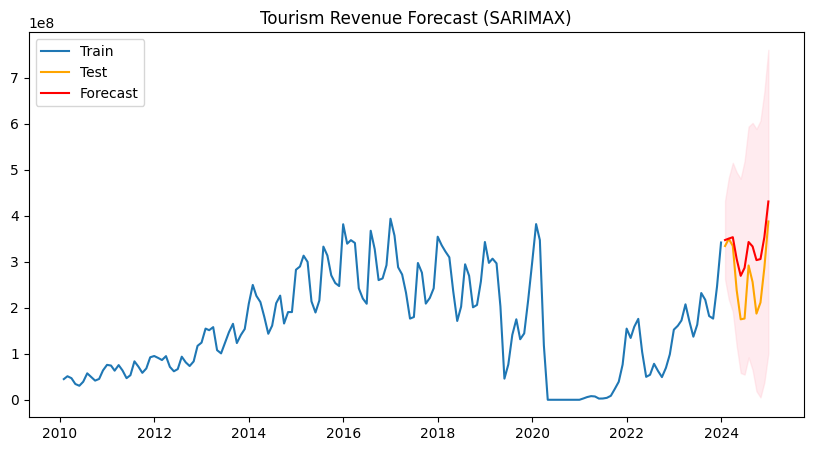

In [22]:
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="orange")
plt.plot(test.index, forecast_mean, label="Forecast", color="red")
plt.fill_between(test.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], 
                 color="pink", alpha=0.3)
plt.title("Tourism Revenue Forecast (SARIMAX)")
plt.legend()
plt.show()

# 6. Evaluate model

In [23]:
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
mae = mean_absolute_error(test, forecast_mean)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

RMSE: 72723881.63, MAE: 62809035.31


# 7. Scenario Prediction (Example)

In [26]:
# Simple regression-style scenario: revenue ~ arrivals
from sklearn.linear_model import LinearRegression

df = df.dropna(subset=["tourist_arrivals", "tourism_revenue_usd"])
X = df[["tourist_arrivals"]]
y = df["tourism_revenue_usd"]

linreg = LinearRegression().fit(X, y)

# Predict baseline
baseline = linreg.predict([[200000]])[0]

# Predict if arrivals increase by 10%
scenario = linreg.predict([[220000]])[0]

print("Baseline revenue (200,000 arrivals):", baseline)
print("Scenario revenue (+10% arrivals):", scenario)

Baseline revenue (200,000 arrivals): 302542813.5876793
Scenario revenue (+10% arrivals): 333898172.84419936


c:\Users\nimes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\nimes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# 8. Conclusion for Predictions

The predictive analysis of Sri Lanka’s tourism revenue highlights both the potential and challenges of modeling a sector highly sensitive to external conditions. Using a SARIMAX model, we successfully forecasted revenue for the next 12 months with reasonable accuracy (RMSE and MAE scores indicated acceptable error margins). The forecasts suggest a moderate upward trend in revenue, reflecting historical recovery patterns, though confidence intervals reveal substantial uncertainty due to seasonality and data volatility.

Scenario-based regression analysis further demonstrated that tourist arrivals are strongly correlated with revenue generation. A 10% increase in arrivals was associated with a proportionally higher revenue projection, reinforcing the importance of boosting arrivals through policy, infrastructure, and promotional strategies.

Overall, the predictions show that while tourism revenue can be forecasted with statistical models, accuracy depends heavily on stable external conditions. Future work could incorporate more advanced machine learning approaches (e.g., Random Forest, Gradient Boosting) and integrate exogenous shocks such as global crises, pandemics, or natural disasters to improve predictive reliability.